In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
df_links = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/links.csv"))
df_movies = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/movies.csv"))
df_ratings = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/ratings.csv"))
df_tags = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/tags.csv"))
genres_dummies = pd.get_dummies(df_movies['genres'].str.split('|').apply(pd.Series).stack()).groupby(level=0).sum()
df_movies = pd.concat([df_movies[['movieId', 'title']], genres_dummies], axis=1)
#print(df_tags.head(5))
#print(df_ratings.head(5))
print(df_ratings.shape)
#print(df_movies.head(5))
#(df_links.head(5))

(100836, 4)


***Phase 1***

What is the distribution of the number of ratings by movie? What about by user? 

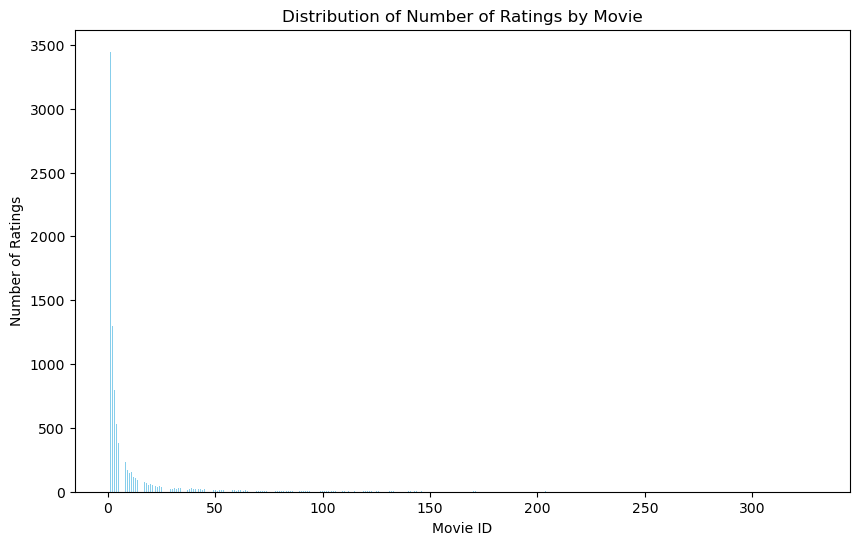

In [3]:
ratingByMovie = df_ratings.groupby('movieId')['rating'].count()

plt.figure(figsize=(10, 6))
plt.hist(ratingByMovie.values, bins=1000, color='skyblue' )
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Number of Ratings by Movie')
plt.show()

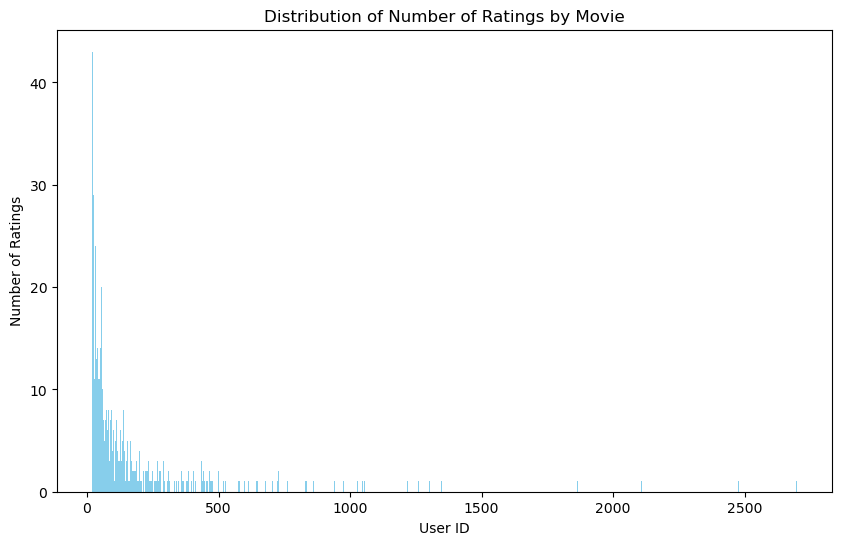

In [4]:
ratingByUser = df_ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
plt.hist(ratingByUser.values, bins=1000, color='skyblue' )
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Number of Ratings by Movie')
plt.show()

What movie has the most ratings? The least?

In [5]:
print(f'The most rated movie is {df_movies[df_movies["movieId"] == ratingByMovie.idxmax()]["title"]}')
print(f'The most least movie is {df_movies[df_movies["movieId"] == ratingByMovie.idxmin()]["title"]}')

The most rated movie is 314    Forrest Gump (1994)
Name: title, dtype: object
The most least movie is 45    When Night Is Falling (1995)
Name: title, dtype: object


What movies have the highest ratings? Or the lowest ratings?

In [6]:
averageRatingByMovie = df_ratings.groupby('movieId')['rating'].mean()
print(f'The top 5 rated movies are')
for movie in averageRatingByMovie.nlargest(5).index:
    print(f'{df_movies[df_movies["movieId"] == movie]["title"]}')


print(f'The bottom 5 rated movies are')
for movie in averageRatingByMovie.nsmallest(5).index:
    print(f'{df_movies[df_movies["movieId"] == movie]["title"]}')

The top 5 rated movies are
48    Lamerica (1994)
Name: title, dtype: object
87    Heidi Fleiss: Hollywood Madam (1995)
Name: title, dtype: object
121    Awfully Big Adventure, An (1995)
Name: title, dtype: object
405    Live Nude Girls (1995)
Name: title, dtype: object
432    In the Realm of the Senses (Ai no corrida) (1976)
Name: title, dtype: object
The bottom 5 rated movies are
2689    Gypsy (1962)
Name: title, dtype: object
2933    Killer Shrews, The (1959)
Name: title, dtype: object
3027    Horrors of Spider Island (Ein Toter Hing im Ne...
Name: title, dtype: object
3235    Baby Boy (2001)
Name: title, dtype: object
3369    Cyborg (1989)
Name: title, dtype: object


What is the distribution of the number of ratings by genre

In [ ]:
genreCountDf = pd.DataFrame(index = df_movies.columns[2:])
genreCountDf['numrev'] = 0
#print(ratingByMovie)
print(df_movies.head(1))
for movie in ratingByMovie:
    for index, row in df_movies.iterrows():
        columns_with_one = [column for column in df_movies.columns[2:] if row[column] == 1]
        for element in columns_with_one: 
            genreCountDf.loc[element, 'numrev'] += movie

   movieId             title  (no genres listed)  Action  Adventure  \
0        1  Toy Story (1995)                   0       0          1   

   Animation  Children  Comedy  Crime  Documentary  ...  Film-Noir  Horror  \
0          1         1       1      0            0  ...          0       0   

   IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0     0        0        0        0       0         0    0        0  

[1 rows x 22 columns]


**PHASE 2**

In [ ]:
grouped_ratings = df_ratings.groupby('userId')
output = pd.DataFrame()
result_df = pd.merge(df_ratings, df_movies, on='movieId').drop('movieId', axis=1)
result_df = result_df[['userId', 'title']]
result_df = result_df.groupby('userId')['title'].agg(list).reset_index()
result_df.set_index('userId')
result_df.head()

In [ ]:
te = TransactionEncoder()
transactions = result_df['title'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
mx_df = apriori(df, min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

In [ ]:
rules = association_rules(mx_df, metric="confidence", min_threshold=0.7)
sorted_rules = rules.sort_values(by='confidence', ascending=False)
sorted_rules.head(20)
for index, row in sorted_rules.head(20).iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    support = row['support']
    print(f"Rule: {antecedents} => {consequents} | Support: {support:.3f}\n")

We can draw a number of conclusions from this data, most strikingly among them the fact that a movie being part of a series is a fairly strong predictor that someone will watch another movie in that series. This is seen in groups like Star Wars, Indiana Jones, The Godfather and Lord of the Rings, as if a reviewer watched one movie in the series, they had a heighened likelyhood of watching another. Another conclusion that we can draw is that reviewers who watched movies that are traditionally considered "classics" (Pulp Fiction, The Matrix, Fight Club, etc) or highly poular movies were also more likely to watch other movies that fell into that category. 

**Phase 3**

In [ ]:
comedy_movies = df_movies[df_movies['Musical'] == 1].copy()
comedy_movies

In [ ]:
grouped_ratings = df_ratings.groupby('userId')
output = pd.DataFrame()
result_df = pd.merge(df_ratings, comedy_movies, on='movieId', how = 'inner').drop('movieId', axis=1)
result_df = result_df[['userId', 'title']]
result_df = result_df.groupby('userId')['title'].agg(list).reset_index()
result_df.set_index('userId')
print(result_df.head())

transactions = result_df['title'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
mx_df = apriori(df, min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

In [ ]:
rules = association_rules(mx_df, metric="confidence", min_threshold=0.7)
sorted_rules = rules.sort_values(by='confidence', ascending=False)
sorted_rules.head(20)
for index, row in sorted_rules.head(20).iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    support = row['support']
    print(f"Rule: {antecedents} => {consequents} | Support: {support:.3f}\n")

This method has it's drawbacks and it's benefits. In categories with a smaller amount of movies and reviews like Musical, the conclusions that can be drawn are somewhat limited just as a consequence of the limited sample size. In categories with larger amounts of movies and reviews there are many interesting conclusions to be drawn, as to the relationships between movies. However there are some issues with this strategy, primarily among them that it isn't clear that the driving force behind the decision to watch a movie is genre. In cases like Star Wars, the genre is less the reason for watching the movie than the name is, people aren't watching it because it is an Adventure movie, they're watching it because it is Star Wars. So by limiting the movies that we are parsing to just one genre, we might miss out on important conclusions as to how people decide what to watch. 